<a href="https://colab.research.google.com/github/Miragecore/LiveStitching/blob/main/FrameStitcher.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import cv2

#SIFT or SURF는 4.3이상의 버전에서만 사용가능하다. 
if cv2.__version__ != "4.4.0":
  print(cv2.__version__)
  #설치후에는 런타임을 재시작해줘야 한다.
  !pip install opencv-contrib-python==4.4.0.44

from google.colab.patches import cv2_imshow

In [2]:
#image의 외곽 좌표를 np.array로 리턴
def getImageCorner(img):
  h, w = img.shape[:2]
  return np.float32([ [0,0],[0,h],[w,h],[w,0]])

In [3]:
#입력 이미지의 그레이 이미지 복사본을 리턴
def getGrayImage(img):
  if len(img.shape) > 2:
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  else :
    return img.copy()

In [4]:
#dst의 roi 영역에 src 이미지를 설정
def copyImageROI(src, dst, x, y):
  h,w = src.shape[:2]

  assert dst.shape[0] > y+h, 'size error : ' + str(dst.shape[0]) + ' < ' \
                                             + str(y+h)
  assert dst.shape[1] > x+w, 'size error : ' + str(dst.shape[1]) + ' < ' \
                                             + str(x+w)

  dst[y:y+h, x: x+w] = src

In [5]:
#변환된 영역의 외곽 좌표 찾기
def getTfCorner(c1, c2):
  corner = np.concatenate((c1, c2), axis=0)
  [xmin, ymin] = np.int32(corner.min(axis=0).ravel())
  [xmax, ymax] = np.int32(corner.max(axis=0).ravel())
  return xmax, xmin, ymax, ymin

In [6]:
def cvimshow(label, img):
  print(label)
  cv2_imshow(img)

In [13]:
class FrameStitcher:
    '''
    FrameStitcher는 입력되는 이미지의 피처를 매칭하고, 
    변환 행렬을 찾아서 이미지 합성을 하는 기능을 한다.

    Args:
        w : 결과 이미지의 Width    
        h : 결과 이미지의 Height
    '''
    def __init__(self, w, h):
      #ORB Dector init   
      #self.detector= cv2.ORB_create()
      self.detector = cv2.SIFT_create()

      #FLANN Matcher init
      #When ORB
      #FLANN_INDEX_LSH = 6
      #index_params = dict(algorithm=FLANN_INDEX_LSH, table_number=6, key_size=12,\
      #                    multi_probe_level=1)

      #SIFT
      FLANN_INDEX_KDTREE = 1
      index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
      search_params = dict(checks = 50)

      self.matcher = cv2.FlannBasedMatcher(index_params, search_params)
      
      #최소 매칭 수
      self.MIN_MATCH_COUNT = 4

      #현재 프레임 카운트
      self.frame_count = 0

      #최종 결과 이미지의 크기 설정 및 초기화
      self.output_frame_w = w
      self.output_frame_h = h
      self.outputframe = np.zeros((h,w,3), np.uint8)
      
      kernel = np.ones((5,5),np.uint8)
      self.kernel = (kernel == 1).astype('uint8')

      self.last_roi = []

      #마지막 프레임 keypoint, descriptor
      self.kp = None
      self.desc = None

    #초기 이미지를 설정한다.
    def initFirstFrame(self, frame):
      #카메라 프레임은 항상 동일한 크기로 가정
      self.frame_h, self.frame_w = frame.shape[:2]
      #동일한 영상이면 매 프레임마다 최외곽 좌표도 동일함
      self.last_frame_corner = getImageCorner(frame).reshape(-1,1,2)
      
      #화면 중앙으로 보내기 위한 변환 매트릭스 생성
      tx = round(self.output_frame_w /2 - self.frame_w /2)
      ty = round(self.output_frame_h/2 - self.frame_h /2)
      self.M = np.array([[1, 0, tx], [0, 1, ty], [0,0,1]])
      
      kp, desc = self.findFeature(frame)

      self.kp = kp
      self.desc = desc

      #처음은 단순 평행이동이어서 계산이 필요없긴 하다.
      self.last_roi = cv2.perspectiveTransform(self.last_frame_corner, self.M)
      copyImageROI(frame, self.outputframe, tx,ty)
      self.frame_count += 1
      
    #추가되는 이미지를 설정
    def setFrame(self, frame):
      #한번 실행되고 매번 검사하는 것은 고민해볼 문제
      if self.frame_count == 0:
        self.initFirstFrame(frame)
        return self.outputframe

      kp1, desc1 = self.findFeature(frame)

      #Good Feature는 knn 1,2번간 거리 70%를 기준으로 찾음
      good = self.findGoodMatch(desc1, self.desc)

      if len(good) < self.MIN_MATCH_COUNT:
        return self.outputframe

      #frame을 outputframe으로 변환 할 것이이므로 src가 최근 입력된 프레임으로
      src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ])\
      .reshape(-1,1,2)
      dst_pts = np.float32([ self.kp[m.trainIdx].pt for m in good ])\
      .reshape(-1,1,2)

      #변환 매트릭스 찾기
      H, RANSAC_mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)

      #외곽 좌표 변환
      #카메라라면 corner도 불변, 불필요
      corner = getImageCorner(frame).reshape(-1,1,2)  
      #변환된 영역의 최와곽 좌표
      tf_corner = cv2.perspectiveTransform(corner,H)
      #변환후 영역 계산
      xmax, xmin, ymax, ymin = getTfCorner(self.last_frame_corner,tf_corner)

      #변환후 입력된 프레임의 위치를 기준 이미지 대비하여 평행 이동
      t = [-xmin,-ymin]
      Ht = np.array([[1,0,t[0]],[0,1,t[1]],[0,0,1]])
      Ht = Ht.dot(H)
      
      #합성 계산의 영역을 최소화하기 위하여 ROI 기반으로 계산
      roix = round(self.last_roi[0][0][0] +xmin)
      roiy = round(self.last_roi[0][0][1] +ymin)
      roiw = xmax - xmin
      roih = ymax - ymin

      source_roi = self.outputframe[roiy:roiy+roih, roix:roix+roiw]
      
      #영상 변환 & 마스크 생성
      warp_img = cv2.warpPerspective(frame,Ht,(roiw, roih))
      wg = getGrayImage(warp_img)
      _, warp_mask = cv2.threshold(wg, 0, 255, cv2.THRESH_BINARY)

      #겹치지 않게 합성하기 위한 erode
      warp_mask = cv2.erode(warp_mask, self.kernel, \
                            borderType=cv2.BORDER_CONSTANT)
      warp_mask_inv = cv2.bitwise_not(warp_mask)

      masked_fg = cv2.bitwise_and(warp_img, warp_img, mask=warp_mask)
      masked_bg = cv2.bitwise_and(source_roi, source_roi, mask=warp_mask_inv)
      added = masked_fg + masked_bg #cv2.add()

      #cv2_imshow(added)
      self.outputframe[roiy:roiy+roih, roix:roix+roiw] = added

      #마지막 프레임 keypoint & descriptor update   
      #카메라 영상이면 이미지 크기가 항상 동일하므로 불변, 불필요
      self.last_frame_corner = getImageCorner(frame).reshape(-1,1,2)
      
      #ROI 업데이트 = 합성 이미지상에서 마지막 입력 프레임의 위치
      self.last_roi[0][0][0] += tf_corner[0][0][0]
      self.last_roi[0][0][1] += tf_corner[0][0][1]
      
      #다음 프레임 처리를 위해 마지막 프레임 정보 저장
      self.kp = kp1
      self.desc = desc1
      self.frame_count += 1

    #2장의 이미지를 입력 받아서 keypoint와 변환 매트릭스를 리턴
    def findFeature(self, img,detector_type = 'SIFT', mask_enable=False,\
                  min_match_count = 10):
      #흑백 이미지 생성
      img_gray = getGrayImage(img)

      #이미지에서 0인 영역으로 마스크를 생성시켜 계산의 속도 향상, 
      #검은 영역이 없다면 무쓸모
      mask = None
      if(mask_enable):
        _, mask = cv2.threshold(img_gray, 1, 255, cv2.THRESH_BINARY)
      
      #keypoint와 Descriptor 찾기
      kp, desc = self.detector.detectAndCompute(img, mask)

      return kp, desc

    #Descriptor를 비교하여 매치 상태가 좋은 점들만 리턴
    def findGoodMatch(self, desc1, desc2, \
                      matcher_type = 'FLANN', \
                      best_match_count = 2, \
                      match_dist = 0.7): 
      matches = self.matcher.knnMatch(desc1,desc2,k=best_match_count)

      good = []
      for m_n in matches:
        if len(m_n) != 2:
          continue
        (m,n) = m_n
        if m.distance < match_dist *n.distance:
            good.append(m)
      return good



In [14]:
import os;

#구글 드라이브 마운트
from google.colab import drive

drive.mount('/content/drive')

#드라이브안에서 프로젝트 드라이브로 이동
root_path = '/content/drive/MyDrive/SandBox/Stitch/earring'

os.chdir(root_path);

!pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/SandBox/Stitch/earring


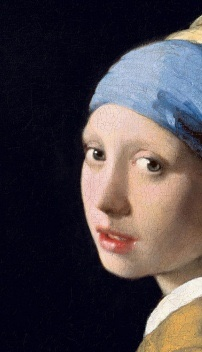

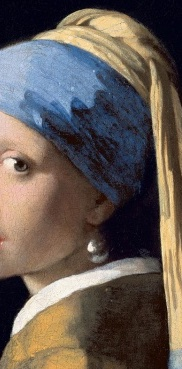

In [15]:
#먼저 업로드해둔 이미지 파일들
image_files = [
    'earring_1.jpg',
    'earring_2.jpg',
    'earring_3.jpg']

img1 = cv2.imread(image_files[0])
img2 = cv2.imread(image_files[1])
img3 = cv2.imread(image_files[2])
cv2_imshow(img1)
cv2_imshow(img2)

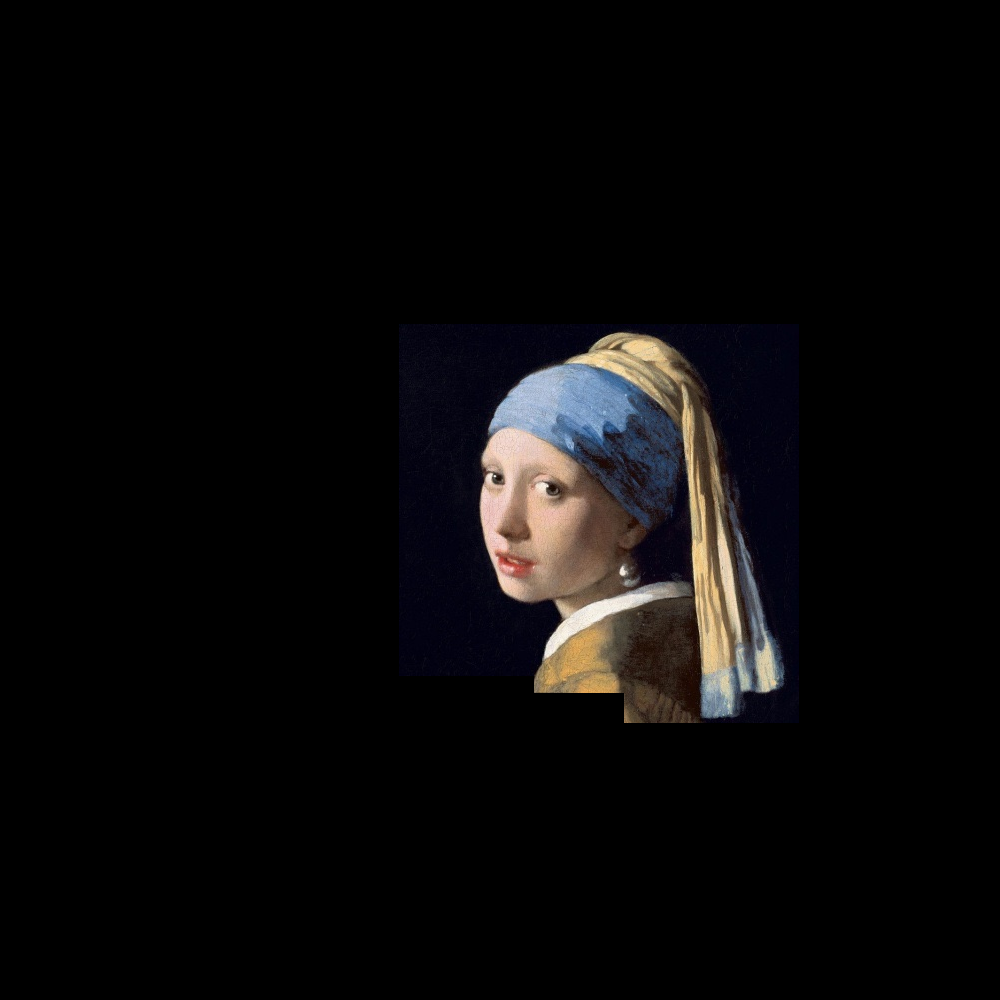

In [16]:
fs = FrameStitcher(1000, 1000)

fs.setFrame(img1)
fs.setFrame(img2)
fs.setFrame(img3)

cv2_imshow(fs.outputframe)